In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/train.csv')


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'])
vocab_size = len(tokenizer.word_index) + 1

In [ ]:

train_sequences = tokenizer.texts_to_sequences(train_df['text'])
test_sequences = tokenizer.texts_to_sequences(test_df['text'])

In [ ]:
max_length = 50
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')


In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=32, input_length=max_length),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(64),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_padded, train_df['target'], epochs=5, validation_split=0.2)


Epoch 1/5
153/153 [==============================] - 19s 84ms/step - loss: 0.6673 - accuracy: 0.6115 - val_loss: 0.6456 - val_accuracy: 0.6232
Epoch 2/5
153/153 [==============================] - 12s 77ms/step - loss: 0.5390 - accuracy: 0.7617 - val_loss: 0.5801 - val_accuracy: 0.7397
Epoch 3/5
153/153 [==============================] - 12s 75ms/step - loss: 0.4354 - accuracy: 0.8415 - val_loss: 0.6166 - val_accuracy: 0.7258
Epoch 4/5
153/153 [==============================] - 12s 81ms/step - loss: 0.4188 - accuracy: 0.8528 - val_loss: 0.6116 - val_accuracy: 0.7323
Epoch 5/5
153/153 [==============================] - 12s 82ms/step - loss: 0.3620 - accuracy: 0.8832 - val_loss: 0.7268 - val_accuracy: 0.7036


In [ ]:
y_pred_probs = model.predict(test_padded)
y_pred = (y_pred_probs > 0.5).astype(int)


In [ ]:
accuracy = accuracy_score(test_df['target'], y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7025607353906763


In [ ]:
conf_matrix = confusion_matrix(test_df['target'], y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[577 297]
 [156 493]]


In [ ]:
classification_rep = classification_report(test_df['target'], y_pred)
print('Classification Report:')
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       874
           1       0.62      0.76      0.69       649

    accuracy                           0.70      1523
   macro avg       0.71      0.71      0.70      1523
weighted avg       0.72      0.70      0.70      1523



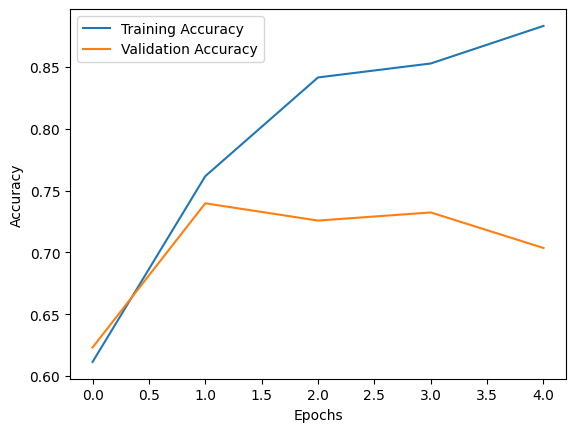

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

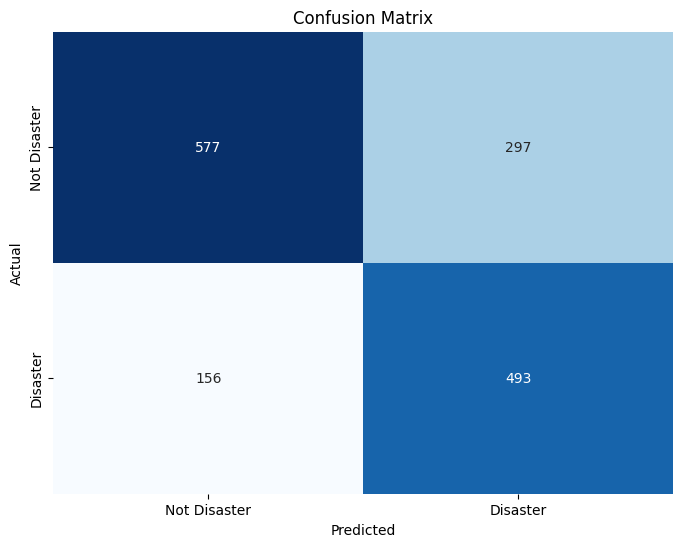

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('your_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = keras.models.load_model('your_model.h5')

In [ ]:
new_test_df = pd.read_csv('/content/test.csv')

In [ ]:
new_test_sequences = tokenizer.texts_to_sequences(new_test_df['text'])
new_test_padded = pad_sequences(new_test_sequences, maxlen=max_length, padding='post')

In [ ]:
new_y_pred_probs = loaded_model.predict(new_test_padded)
new_y_pred = (new_y_pred_probs > 0.5).astype(int)

102/102 [==============================] - 7s 47ms/step


In [ ]:
new_test_df['predicted_target'] = new_y_pred
print(new_test_df[['text', 'predicted_target']])

                                                   text  predicted_target
0                    Just happened a terrible car crash                 0
1     Heard about #earthquake is different cities, s...                 1
2     there is a forest fire at spot pond, geese are...                 1
3              Apocalypse lighting. #Spokane #wildfires                 0
4         Typhoon Soudelor kills 28 in China and Taiwan                 1
...                                                 ...               ...
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...                 1
3259  Storm in RI worse than last hurricane. My city...                 1
3260  Green Line derailment in Chicago http://t.co/U...                 1
3261  MEG issues Hazardous Weather Outlook (HWO) htt...                 1
3262  #CityofCalgary has activated its Municipal Eme...                 1

[3263 rows x 2 columns]
